# Handwritten digit recognition on MNIST dataset using a Deep Neural Network

## 1. First let's import all the necessary modules.

In [1]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

%matplotlib inline

## 2. Data Preprocessing and visualization.

More detail on the dataset <a href='http://yann.lecun.com/exdb/mnist/'>here.</a>

### 2.1 Let's load the dataset in (X, Y)train and (X, Y)test.
* We divide the dataset into train and test so our Neural Network can learn from train data and we can test how good the network has learned with test data

In [2]:
mnist = MNIST('../dataset/MNIST/')
x_train, y_train = mnist.load_training() #60000 samples
x_test, y_test = mnist.load_testing()    #10000 samples

x_train = np.reshape(np.asarray(x_train).astype(np.float32), (60000, 784))  
y_train = np.reshape(np.asarray(y_train).astype(np.float32), (60000, 1))  
x_test = np.reshape(np.asarray(x_test).astype(np.float32), (10000, 784))
y_test = np.reshape(np.asarray(y_test).astype(np.float32), (10000, 1))  

### 2.2 Summary.

In [3]:
print(f"Number of examples in training set: {x_train.shape[0]}")
print(f"Number of examples in test set: {x_test.shape[0]}")
print(f"Size of the image is {x_train.shape[1]} i.e. (28,28,1) pixels")

Number of examples in training set: 60000
Number of examples in test set: 10000
Size of the image is 784 i.e. (28,28,1) pixels


### Size of the image is 784 because we are taking the 28 X 28 image in 784 rows each containing one pixel

![alt_text](./images/nn.png)

### 2.3 Printing image.

In [4]:
def print_random_images(x, y):
    fig=plt.figure(figsize=(10, 10))
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        index = random.randint(0, len(x) -1)
        img = x[index].reshape(28, 28)
        axes = fig.add_subplot(rows, columns, i, title=y[index][0])
        fig.tight_layout(pad=2.0)
        axes.axis('off')
        plt.imshow(img, cmap='gray')
        
    plt.show()

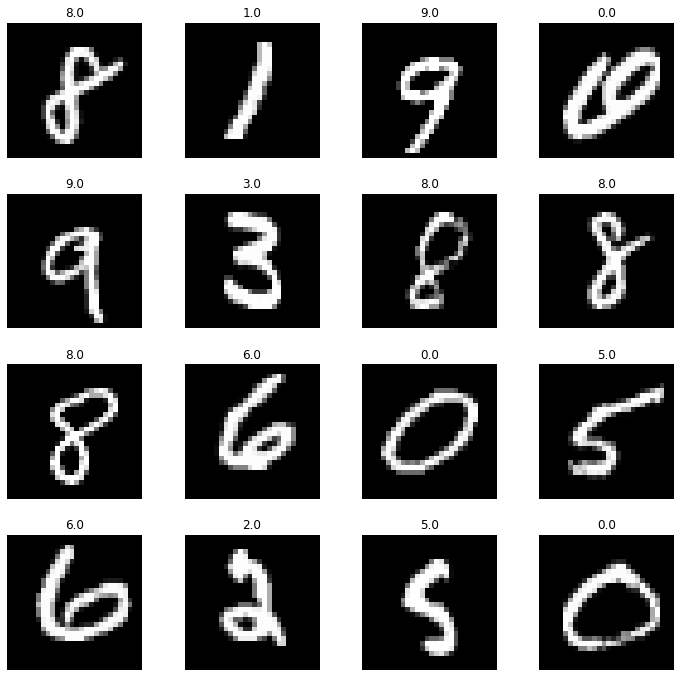

In [5]:
print_random_images(x_train, y_train)

## 3. Building the Neural Network step by step.

### 3.1 Initializing the parameters of the network.

In [6]:
def initi_params(layer_dims):
    np.random.seed(3)
    params = {}
    L = len(layer_dims)           

    for l in range(1, L):
        params['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        params['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(params['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(params['b' + str(l)].shape == (layer_dims[l], 1))
  
    return params

### 3.2 Activation functions.

* Activation functions are used to learn complex patterns in data.
* They define which neurons should be fired in next layer.
* In our case we will be using ReLU activation for every layer except the last. The last layer will have a softmax  classifier.

In [6]:
def relu(Z):
    A = np.maximum(0, Z)
    return A, Z


def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ


def stable_softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True) , Z

### 3.3 Forward Propagation.
<br>
Forward propgation refers to passing the data in neural network in forward direction to make the prediction.

![alt text](./images/forwardpropnet.gif)

In [7]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)   
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
    if activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = stable_softmax(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache


def L_model_forward(X, params):
    caches = []
    A = X
    L = len(params) // 2
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, params['W'+str(l)], params["b"+str(l)], 'relu')
        caches.append(cache)

    AL, cache = linear_activation_forward(A, params["W"+str(L)], params["b"+str(L)], 'softmax')
    caches.append(cache)
    assert(AL.shape == (10,X.shape[1]))
    return AL, caches

### 3.4 Cost Function.

* Cost function gives an estimate on how bad or good the network is at making predictions
* The smaller value of the cost function indicates that the neural network is making resonably good predictions
* So in practice we always try to reduce the value of the cost function

In [9]:
def compute_cost(AL, Y):
    #cost = -1 * np.mean(Y*(AL + (-AL.max() - np.log(np.sum(np.exp(AL - AL.max()))))))
    cost = -np.mean(Y.T * np.log(AL.T + 1e-8))
    return cost

### 2.4 Backward Propagation.
<br>
As you can tell from the name Backward propagation or backprop is used to navigate backwards in the neural network and fine tune all the parameters of network.

![alt_text](./images/backprop.gif)

In [8]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m
    db = (np.sum(dZ, axis=1)).reshape(b.shape[0],b.shape[1]) / m    
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    Y = Y.reshape(AL.shape)
    dZ = AL - Y                 # derivative of cross entropy wrt activation func(final layer)
    
    current_cache = caches[L-1]
    linear_cache, _ = current_cache
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(dZ, linear_cache)
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### 2.5 Update function to update parameters.

In [11]:
def update_params(params, grads, learning_rate=0.05):
    L = len(params) // 2
    for l in range(L):
        params["W" + str(l+1)] = params["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        params["b" + str(l+1)] = params["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return params

### 2.6 Combining everything together in a model.

In [12]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.5, num_iterations = 3000, print_cost=True):#lr was 0.009
    costs = []                      
    
    params = initi_params(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, params)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        params = update_params(params, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return params

## 4. Creating, Training the Model and making predictions using it.

![alt_text](./images/training.gif)

In [13]:
network = np.array([784, 16, 16, 10])       # Linear-->Relu  Linear-->Relu  Linear-->Softmax
parameters = initi_params(network)

### 4.1 First we need to convert the output vectors in a one hot encoding.

![alt_text](./images/onehot.jpg)

In [8]:
def one_hot_matrix(Y):
    Y = Y.astype(np.int).T
    hot = np.zeros((Y.size, int(Y.max()+1)))
    hot[np.arange(Y.size), Y] = 1
    
    return hot.T

In [9]:
one_hot_y_train = one_hot_matrix(y_train.squeeze())
one_hot_y_test = one_hot_matrix(y_test.squeeze())

### 4.2 Training the model.

Cost after iteration 0: 0.230258
Cost after iteration 100: 0.230116
Cost after iteration 200: 0.230097
Cost after iteration 300: 0.230031
Cost after iteration 400: 0.228365
Cost after iteration 500: 0.160799
Cost after iteration 600: 0.121700
Cost after iteration 700: 0.092849
Cost after iteration 800: 0.065600
Cost after iteration 900: 0.055643
Cost after iteration 1000: 0.049369
Cost after iteration 1100: 0.044140
Cost after iteration 1200: 0.038908
Cost after iteration 1300: 0.034632
Cost after iteration 1400: 0.031632
Cost after iteration 1500: 0.029336
Cost after iteration 1600: 0.027502
Cost after iteration 1700: 0.026105
Cost after iteration 1800: 0.024605
Cost after iteration 1900: 0.023423
Cost after iteration 2000: 0.022258
Cost after iteration 2100: 0.021274
Cost after iteration 2200: 0.020370
Cost after iteration 2300: 0.019609
Cost after iteration 2400: 0.018864
Cost after iteration 2500: 0.018389
Cost after iteration 2600: 0.017695
Cost after iteration 2700: 0.017265
Cost

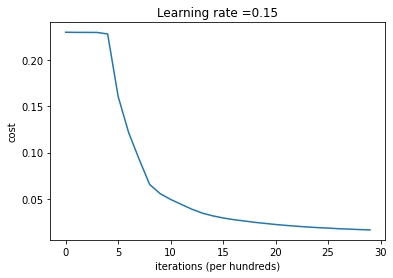

In [16]:
x_train = x_train / 255 #normalizing the data
trained_params = L_layer_model(x_train.reshape(60000,784).T , one_hot_y_train, [784, 16, 16, 10], num_iterations=3000, learning_rate=0.15)

### 4.5 Saving the trained parameters of the model.

Saving the model because the training process is very time consuming and resource heavy.

In [17]:
# with open('digit_model.pickle', 'wb') as f:
#     pickle.dump(trained_params, f)

### 4.3 Predicting on trained parameters.

In [10]:
x_test = x_test / 255 # Normalizing the test data

In [11]:
# Loading the saved model
with open('digit_model.pickle', 'rb') as pickle_file:
    trained_params = pickle.load(pickle_file)

In [12]:
def predict(X, trained_params, actual, total_examples, name):
    predictions, caches = L_model_forward(X, trained_params)
    predictions = predictions.T
    correct = 0
    incorrect = 0

    for i in range(total_examples): # 60000
        for j in range(10): # 10
            if predictions[i][j] == max(predictions[i]):
                predictions[i][j] = 1
            else:
                predictions[i][j] = 0

    for k in range(total_examples):
        for l in range(10):
            if predictions[k][l] == 1:
                if predictions[k][l] == actual[k][l]:
                    correct += 1
                else:
                    incorrect += 1
    print(f"{name} accuracy: {correct*100 /total_examples} %")         
    
    return predictions

In [13]:
preds_test = predict(x_test.T, trained_params, one_hot_y_test.T, 10000, 'Test')

Test accuracy: 94.61 %


### 4.4 Checking if predictions and original image match.

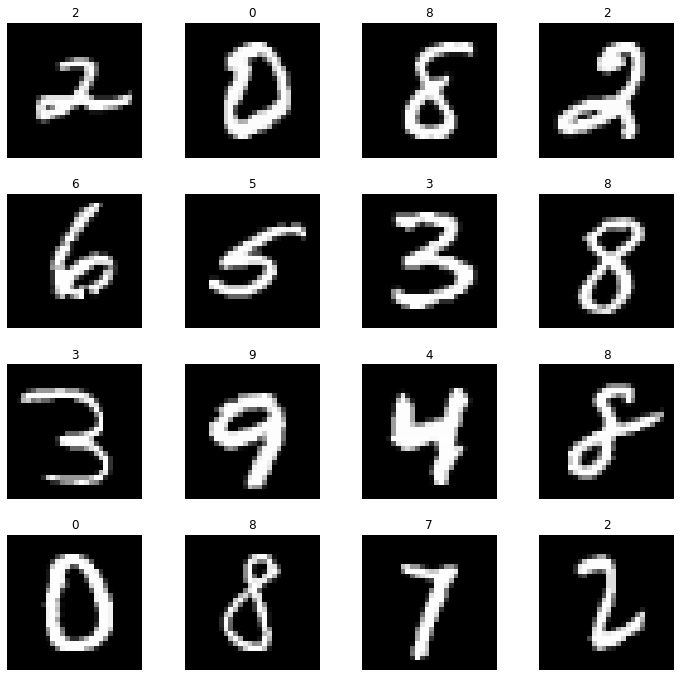

In [14]:
print_random_images(x_test, np.argmax(preds_test, axis=1).reshape(10000, 1))